### Importing the Dataset

In [136]:
import numpy as np
import pandas as pd

posts = pd.read_csv("../data/total_posts.csv", names=["text", "user", "label", "date"])

posts['label'] = pd.to_numeric(posts['label'], errors='coerce')
posts = posts.dropna(subset=['label'])

/tmp/ipykernel_745160/927668617.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  posts = pd.read_csv("../data/total_posts.csv", names=["text", "user", "label", "date"])


In [137]:
posts.head()

,text,user,label,date
0,Happy new years heres a story for yall! So th...,"""HHeysu27""",1.0,2019-12-31
1,Ok is it me or does anyone else get sad during...,"""Supreme_Spencer""",1.0,2019-12-31
2,What should the first word of the decade be? I...,"""Yourmotherisobese""",1.0,2019-12-31
3,Happy new year from England it is currently 00...,"""wilddildo""",1.0,2019-12-31
4,Well guys F in the chat for the 2010s' decade ...,"""Phantompyroblaze""",1.0,2019-12-31


In [138]:
new_texts = {}

In [139]:
for text, user, label in zip(posts['text'], posts['user'], posts['label']):
  if label > 1: continue
  if user not in new_texts:
    new_texts[user] = [text, label]
  else:
    new_texts[user][0] += text

In [140]:
len(new_texts)

150023

In [141]:
posts = pd.DataFrame(index=np.arange(0, len(new_texts)), columns=("text", "label", "length"))

In [142]:
for i, value in enumerate(new_texts.values()):
  value[0] = ' '.join(value[0].split()[:1000])
  posts.loc[i] = [*value, len(value[0].split()) // 10]

### Exploring the Dataset

In [143]:
posts.head()

,text,label,length
0,Happy new years heres a story for yall! So the...,1.0,11
1,Ok is it me or does anyone else get sad during...,1.0,2
2,What should the first word of the decade be? I...,1.0,96
3,Happy new year from England it is currently 00...,1.0,4
4,Well guys F in the chat for the 2010s' decade ...,1.0,35


In [144]:
posts.value_counts(subset='length')

length
2      17142
100    16792
3      10499
4       8005
5       7112
       ...  
99       178
98       176
93       173
1          3
0          3
Name: count, Length: 101, dtype: int64

### Splitting the Dataset

In [145]:
from sklearn.model_selection import train_test_split

strat_train_set, strat_test_set = train_test_split(posts, test_size=0.1, random_state=42, stratify=posts['label'])

#### Analyzing the Dataset

In [146]:
posts = strat_train_set.copy()
posts.head()

,text,label,length
112650,14f europe to America i live pretty much in th...,0.0,4
65797,I am humbly requesting the entire subreddit to...,1.0,3
102472,I'm pretty sure I want to die but I'm so afrai...,0.0,48
92866,[QUESTION] Car or plane? So here's the deal: I...,0.0,52
70324,Got rejected last night Feels bad man. Feels b...,1.0,2


In [147]:
post_lengths = [len(post.split()) for post in posts[posts['label'] == 0]["text"] if len(post.split()) < 10000]

In [148]:
sum(post_lengths) / len(post_lengths)

426.64885013119306

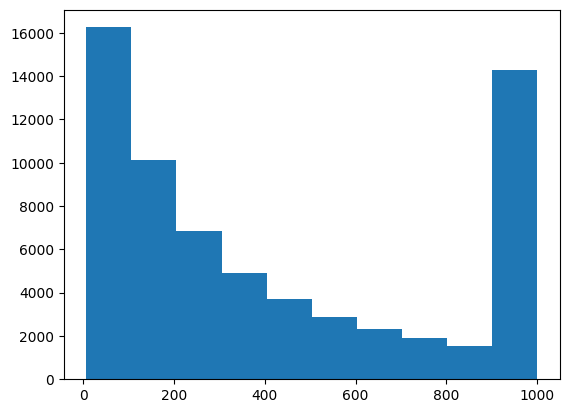

In [149]:
import matplotlib.pyplot as plt

plt.hist(post_lengths, bins=10)
plt.show()

### Preprocessing

#### Creating validation data

In [61]:
strat_train_set, strat_val_set = train_test_split(posts, test_size=1/9, random_state=42, stratify=posts['label'])

strat_train_set[:5]

,text,label
141127,Can I please have someone to vent to my life ...,1.0
26938,Im going to need to delete lots of memes soon....,1.0
730920,So i looked at recent portal results on my hpv...,0.0
696038,Crisis support is a load so an hour talking to...,0.0
939500,New to gunpla always had an interest in the ba...,0.0


#### Tokenizing the posts

In [62]:
import spacy

print(spacy.prefer_gpu())

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

nlp.pipe_names

True


['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']

In [63]:
doc = nlp('I was reading the paper.')
print([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

['read', 'paper']


In [68]:
import pickle
from tqdm import tqdm

def preprocess_set(set, directory):
    print(f'Preprocessing {directory} data')

    texts = set.copy()['text']
    labels = set.copy()['label']
    texts = [' '.join(text.split()[:500]) for text in texts]

    docs = (doc for doc in (nlp.pipe(texts)))
    processed_texts = []
    for doc in tqdm(docs, total=len(texts), ncols=80):
        lemmas = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
        processed_texts.append(' '.join(lemmas))
    
    labels = np.array(labels)

    from pathlib import Path
    Path(f"{directory}").mkdir(parents=True, exist_ok=True)

    with open(f"{directory}/texts.pkl", "wb") as fp:
        pickle.dump(processed_texts, fp)
    
    with open(f"{directory}/labels.pkl", "wb") as fp:
        pickle.dump(labels, fp)

    return processed_texts, labels

In [69]:
len(strat_train_set)

625011

In [70]:
preprocess_set(strat_train_set, 'train')
preprocess_set(strat_val_set, 'val')
preprocess_set(strat_test_set, 'test')

print()

Preprocessing train data


100%|██████████████████████████████████| 625011/625011 [13:48<00:00, 754.50it/s]


Preprocessing val data


100%|████████████████████████████████████| 78127/78127 [01:42<00:00, 765.52it/s]


Preprocessing test data


100%|████████████████████████████████████| 70314/70314 [01:30<00:00, 773.55it/s]